In [31]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import itertools
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
%matplotlib inline

In [13]:
# Spaces for in- and output
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
Z = tp.spaces.R1('z')
U = tp.spaces.R3('u')

# Parameter
fskal =18333
kappa = 18333.3/fskal # GPa = 18333,33 Mpa
mu = 3928.57/fskal # GPa = 3928.57 Mpa
u_dis = 0.2 # mm
size = 5.0  # mm

In [14]:
# Load stl.file and create domain
Ix = tp.domains.Interval(X, -size, size)
Iy = tp.domains.Interval(Y, -size, size)
Iz = tp.domains.Interval(Z, -size, size)
cube = Ix * Iy * Iz

In [15]:
class Sinus(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return torch.sin(input)

In [16]:
# network to train
model = tp.models.Sequential(
    tp.models.NormalizationLayer(cube),
    #tp.models.FCN(activations = Sinus(),input_space=X*Y*Z, output_space=U, hidden=(30,30,30,30,30)))
    #tp.models.FCN(input_space=X*Y*Z, output_space=U, hidden=(32,32,32,32,32))) 
    tp.models.FCN(input_space=X*Y*Z, output_space=U, hidden=(50,50,50),xavier_gains=[5/3,5/3,0]))

In [17]:
inner_sampler = tp.samplers.RandomUniformSampler(cube, n_points = 1000) #.make_static()

fig = tp.utils.scatter(X*Y*Z, inner_sampler)
fig.get_axes()[0].view_init(30, 170)
fig.set_size_inches(6, 4)

In [18]:
x_side_sampler = tp.samplers.RandomUniformSampler(Ix.boundary*Iy*Iz, n_points=200)

y_side_sampler = tp.samplers.RandomUniformSampler(Iy.boundary*Ix*Iz, n_points=200)

top_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_right, n_points=300)
bottom_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_left, n_points=200)

fig = tp.utils.scatter(X*Y*Z, bottom_sampler)
fig.get_axes()[0].view_init(30, 190)
fig.set_size_inches(6, 4)

In [19]:
# Compute C:
def delta(a, b):
    return a == b

C = torch.zeros((3, 3, 3, 3), dtype=torch.float32) # Tensor 4. Stufe R^(3x3x3x3)
for i,j,k,l in itertools.product(range(3), range(3), range(3), range(3)):
    unit_prod = delta(i, j) * delta(k, l) #Kroneckersymbol berechnet; 
    P_sym = 0.5 * (delta(i, k) * delta(j, l) + delta(j, k) * delta(i, l)) - 1/3.0*unit_prod
    C[i,j,k,l] = kappa * unit_prod + 2*mu*P_sym

# reshape to (9, 1, 3, 3), to apply to batch of the form ("1", batch_dim, 3, 3)
print(kappa)
print(C)
C = C.reshape(9, 1, 3, 3)
#print(C)
if torch.cuda.device_count() > 0:
    C = C.to('cuda')

1.0000163639338897
tensor([[[[1.2857, 0.0000, 0.0000],
          [0.0000, 0.8572, 0.0000],
          [0.0000, 0.0000, 0.8572]],

         [[0.0000, 0.2143, 0.0000],
          [0.2143, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.2143],
          [0.0000, 0.0000, 0.0000],
          [0.2143, 0.0000, 0.0000]]],


        [[[0.0000, 0.2143, 0.0000],
          [0.2143, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000]],

         [[0.8572, 0.0000, 0.0000],
          [0.0000, 1.2857, 0.0000],
          [0.0000, 0.0000, 0.8572]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2143],
          [0.0000, 0.2143, 0.0000]]],


        [[[0.0000, 0.0000, 0.2143],
          [0.0000, 0.0000, 0.0000],
          [0.2143, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.2143],
          [0.0000, 0.2143, 0.0000]],

         [[0.8572, 0.0000, 0.0000],
          [0.0000, 0.8572, 0.0000],
          [0.0000, 0.0000

In [20]:
## test C stuff:
# a = torch.tensor([[[1.0, 0.0, 2.0], [1.0, 1.0, 2.0], [0.0, 1.0, 2.0]], 
#                   [[1.0, 1.0, 2.0], [1.0, 5.0, 2.0], [5.0, 1.0, 2.0]]])
# b = C*a
# print(b.sum(dim=(2, 3)).T.reshape(len(a), 3, 3))

In [21]:
# inner pde condition:
def pde_residual(u, C, x, y, z):
    sym_grad = tp.utils.sym_grad(u, x, y, z)
    prod = C*sym_grad #Spannung
    sigma = (prod.sum(dim=(2, 3))).T.reshape(len(u), 3, 3)
    return tp.utils.matrix_div(sigma, x, y, z) # + forces

def bc_x_residual(u, x, y, z):
    # nur x-Koordinate wird Null gesetzt
    return u #u[:,0:1]

def bc_y_residual(u, x, y, z):
    return u #u[:,1:2]

def bc_z_top_residual(u, x, y, z):
    press =  u_dis * torch.cos(math.pi/10.0 * x) * torch.cos(math.pi/10.0 * y)
    return u[:, 2:] +   press

def bc_z_bottom_residual(u, x, y, z):
    # auf Boden sind alle Komponenten der Verschiebung Null
    return u

pde_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=inner_sampler,
                                            residual_fn=pde_residual,
                                            data_functions={'C': C}, 
                                            weight=1)

bc_x_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=x_side_sampler,
                                            residual_fn=bc_x_residual,
                                            data_functions={'C': C}, 
                                            weight=1)

bc_y_condition = tp.conditions.PINNCondition(module=model,
                                            sampler=y_side_sampler,
                                            residual_fn=bc_y_residual,
                                            data_functions={'C': C}, 
                                            weight=1)

bc_z_top_cond = tp.conditions.PINNCondition(module=model,
                                            sampler=top_sampler,
                                            residual_fn=bc_z_top_residual,
                                            data_functions={'C': C}, 
                                            weight=1)

bc_z_bottom_cond = tp.conditions.PINNCondition(module=model,
                                            sampler=bottom_sampler,
                                            residual_fn=bc_z_bottom_residual,
                                            weight=1)


In [22]:
# Training 
def plot_displacement_x(u, x, y, z):
    # Verschiebung in x-Richtung
    return u[:, 0:1]

def plot_displacement_y(u, x, y, z):
    # Verschiebung in x-Richtung
    return u[:, 1:2]

def plot_displacement_z(u, x, y, z):
    # Verschiebung in x-Richtung
    return u[:, 2:3]

xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 0.0})

optim = tp.solver.OptimizerSetting(torch.optim.Adam, lr=1e-3) #' Adam, Adagrad '
solver = tp.solver.Solver([pde_condition, bc_x_condition, bc_y_condition, bc_z_top_cond, bc_z_bottom_cond],
                          optimizer_setting = optim)

calls = [tp.utils.PlotterCallback(model=model,plot_function=plot_displacement_z,point_sampler=samp,
                        log_name='ausgabe', plot_type='contour_surface',check_interval=10), 
         tp.utils.WeightSaveCallback(model=model,path='.',name='NN',check_interval = 10, save_initial_model=False,
                                    save_final_model = True)]

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=5000, 
                     logger=False, 
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.5 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)
/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [23]:
from matplotlib import pyplot
xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 5.0})
fig = tp.utils.plot(model, plot_displacement_z, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in z-Richtung in [mm]')
#pyplot.savefig('Verschiebung-z-Richtung.png', dvi=360)

/home/krd2rng/.conda/envs/pytorch-physics/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/krd2rng/python/mso-036/src/torchphysics/problem/domains/domain2D/parallelogram.py:134: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/TensorShape.cpp:2318.)
  bary_coords = torch.stack(torch.meshgrid((x, y))).T.reshape(-1, 2)
/home/krd2rng/python/mso-036/src/torchphysi

Text(0.5, 1.0, 'Verschiebung in z-Richtung in [mm]')

In [24]:
xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
xz_square = tp.domains.Parallelogram(X*Z, [-size, -size], [size, -size], [-size, size])
yz_square = tp.domains.Parallelogram(Y*Z, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(yz_square, n_points=1000, data_for_other_variables={'x': 4.0})
fig = tp.utils.plot(model, plot_displacement_x, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in y-Richtung [mm]')
pyplot.savefig('Verschiebung-y-Richtung.png', dvi=720)

<ipython-input-24-5afbc69c4de9>:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  pyplot.savefig('Verschiebung-y-Richtung.png', dvi=720)


In [25]:
# Training mit statischem Sampling
inner_sampler = tp.samplers.RandomUniformSampler(cube, n_points = 32*32*32).make_static()
x_side_sampler = tp.samplers.RandomUniformSampler(Ix.boundary*Iy*Iz, n_points=100).make_static()

y_side_sampler = tp.samplers.RandomUniformSampler(Iy.boundary*Ix*Iz, n_points=100).make_static()

top_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_right, n_points=200).make_static()
bottom_sampler = tp.samplers.RandomUniformSampler(Ix*Iy*Iz.boundary_left, n_points=100).make_static()


xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z': 0.0})

optim = tp.solver.OptimizerSetting(torch.optim.LBFGS, lr=0.1) #' Adam, Adagrad '
solver = tp.solver.Solver([pde_condition, bc_x_condition, bc_y_condition, bc_z_top_cond, bc_z_bottom_cond],
                          optimizer_setting = optim)

calls = [tp.utils.PlotterCallback(model=model,plot_function=plot_displacement_z,point_sampler=samp,
                        log_name='ausgabe', plot_type='contour_surface',check_interval=10), 
         tp.utils.WeightSaveCallback(model=model,path='.',name='NN',check_interval = 10, save_initial_model=False,
                                    save_final_model = True)]

trainer = pl.Trainer(devices=1, accelerator="gpu",
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=300, 
                     logger=False, 
                     enable_checkpointing=False)
trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 5.5 K 
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
5.5 K     Trainable params
0         Non-trainable params
5.5 K     Total params
0.022     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Text(0.5, 1.0, 'Verschiebung in z-Richtung [mm]')

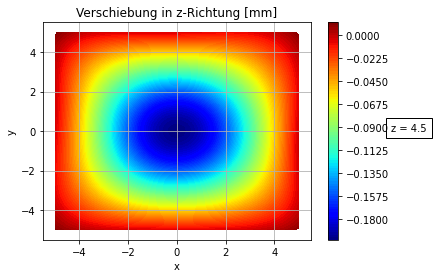

In [32]:
xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=2000, data_for_other_variables={'z': 4.5})
fig = tp.utils.plot(model, plot_displacement_z, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in z-Richtung [mm]')
#pyplot.savefig('Verschiebung-y-Richtung.png', dvi=720)

Text(0.5, 1.0, 'Verschiebung in x-Richtung [mm]')

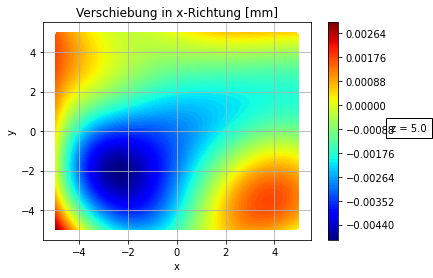

In [33]:
xy_square = tp.domains.Parallelogram(X*Y, [-size, -size], [size, -size], [-size, size])
samp = tp.samplers.PlotSampler(xy_square, n_points=2000, data_for_other_variables={'z': 5.0})
fig = tp.utils.plot(model, plot_displacement_x, samp, plot_type='contour_surface')
pyplot.title('Verschiebung in x-Richtung [mm]')
#pyplot.savefig('Verschiebung-x-Richtung.png', dvi=720)

<ipython-input-34-d537f8130465>:21: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dvi" which is no longer supported as of 3.3 and will become an error two minor releases later
  pyplot.savefig('sigma-x-y-z=45.png', dvi=360)


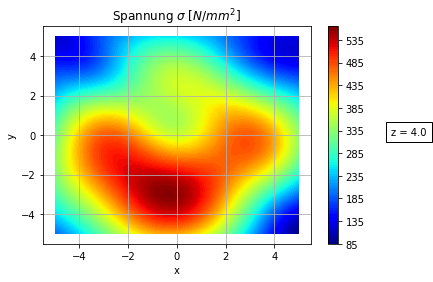

In [34]:
kappa = 18333.3
mu = 3928.57 

C = torch.zeros((3, 3, 3, 3), dtype=torch.float32)
for i,j,k,l in itertools.product(range(3), range(3), range(3), range(3)):
    unit_prod = delta(i, j) * delta(k, l)
    P_sym = 0.5 * (delta(i, k) * delta(j, l) + delta(j, k) * delta(i, l)) - 1/3.0*unit_prod
    C[i,j,k,l] = kappa * unit_prod + 2*mu*P_sym
    
C = C.reshape(9, 1, 3, 3)

def strain_fn(u, x, y, z):
    sym_grad = tp.utils.sym_grad(u, x, y, z)
    prod = C*sym_grad
    sigma = (prod.sum(dim=(2, 3))).T.reshape(len(u), 3, 3)
    return torch.norm(sigma, dim=(1,2))

samp = tp.samplers.PlotSampler(xy_square, n_points=1000, data_for_other_variables={'z':4.0})
fig = tp.utils.plot(model, strain_fn, samp, plot_type='contour_surface')
pyplot.title('Spannung $\sigma$ $[N/mm^2]$')
pyplot.savefig('sigma-x-y-z=45.png', dvi=360)

Text(0, 0.5, 'Spannung $N/mm^2$')

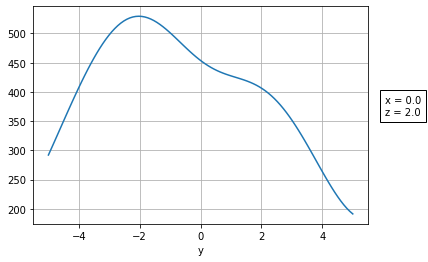

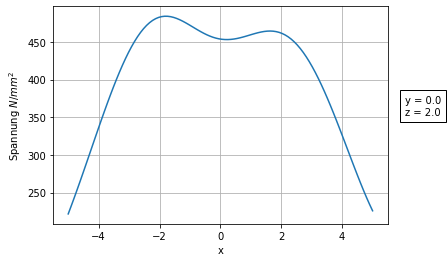

In [35]:
x_interval = tp.domains.Interval(X, -size, size)
y_interval = tp.domains.Interval(Y, -size, size)
z_ebene = 2.0
samp1 = tp.samplers.PlotSampler(y_interval, n_points=100, data_for_other_variables={'x':0.0,'z': z_ebene})
samp2 = tp.samplers.PlotSampler(x_interval, n_points=100, data_for_other_variables={'y':0.0,'z': z_ebene})
fig1 = tp.utils.plot(model, strain_fn, samp1)
fig2 = tp.utils.plot(model, strain_fn, samp2)
pyplot.ylabel('Spannung $N/mm^2$')